# Summary

I will start with linear regression as base model. 

+ I add quantitative features incrementally to see their impact on prediction perf
+ I will also figure out what is the best perf of a linear model

Then we will switch to ensemble models:
+ random forest
+ tune hyperparams of RF to achieve a better model. 
+ finally, I will try XGBoost.

We will pick features based on analysis from EDA notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV

In [2]:
# folder = '/kaggle/input/house-prices-advanced-regression-techniques/'
folder = 'data'

train = pd.read_csv(os.path.join(folder, 'train.csv'))
test = pd.read_csv(os.path.join(folder, 'test.csv'))

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [3]:
# concat train and test sets st we always perform transformation on both sets
test['SalePrice'] = 0
data = pd.concat([train, test])

print(data.shape)

# lowercase all column names for convenience
data.columns = [str.lower(cc) for cc in data.columns]

# sale price per square feet is also interested
data['sale_price_per_sf'] = data['saleprice'] / data['grlivarea']

(2919, 81)


There are two approaches:
+ predict directly sale price
+ predict price per SF, then multiply with living area to estimate sale price

I plan to try both, but first we need some helpers.

## Helper methods

In [4]:
def cal_age_from_built(row):
    return row['yrsold'] - row['yearbuilt']

def cal_age_from_remodel(row):
    return row['yrsold'] - row['yearremodadd']


def fold_zone_type(ms_zone):
    if ms_zone in ['FV', 'RH', 'C (all)']:
        return 'Other'
    else:
        return ms_zone
#         return {'RL': 'Residential Low Density'.lower() , 
#                 'RM': 'Residential Medium Density'.lower(),
#                 None: 'NA'
#                }[ms_zone]    

def to_adjacency(cond):
    if 'RR' in cond:
        return 'Railroad'
    if 'Pos' in cond:
        return 'Positive feature'
    return {
        'Artery': 'Arterial street',
        'Feedr': 'Feeder street',
        'Norm': 'Normal'    
        }[cond]

In [159]:
def onehot_encode(cat_feat, data, dummy_na=False):
    # given a categorical column,
    # perform onehot encode and return encoded DF together with names of new binary columns
    categories = data[cat_feat].unique()
    print('there are', len(categories), 'categories as follows:')
    print(categories)
    
    encoded = pd.get_dummies(data[cat_feat], prefix=cat_feat, dummy_na=dummy_na)
    res = pd.concat([data.drop(columns=[cat_feat]), encoded], axis='columns')
    new_feat_names = ['_'.join([cat_feat, cc]) for cc in categories]
    return res, new_feat_names

def encode_cat_feats(data, cat_feats, dummy_na=False):
    print('Onehot encode categorical features: ', cat_feats)

    encoded_df = data.copy()
    # encode 1 cat feature at a time
    for cf in cat_feats:
        encoded_df, _ = onehot_encode(cf, encoded_df, dummy_na=dummy_na)

    return encoded_df

In [6]:
def list_numeric_columns(data):
    return list(data.columns[np.where(data.dtypes != 'object')])

def list_string_columns(data):
    return list(data.columns[np.where(data.dtypes == 'object')])

def split_train_valid(data, target):
    y = data.pop(target)
    X = data
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.1, 
                                                          random_state=1
                                                         )
    return X_train, X_valid, y_train, y_valid

def check_na(data):
    # check if any NA left
    na_count = [sum(data[ff].isnull()) for ff in data.columns]
    return pd.DataFrame({'column': data.columns, 'na_count': na_count}).\
              query('na_count > 0')   

In [7]:
def to_quantitative(text_feat, df, scoring):
    '''
    Given a feature stored in data as text but actually a quantitative feat, convert it to numerical values
    via given encoding
    :param scoring:
    :param text_feat:
    :return:
    '''
    n_na = sum(df[text_feat].isnull())
    print('\t Feature {0} has {1} NAs, they will be filled by 0'.format(text_feat, n_na))

    res = df.copy()
    res[text_feat].fillna("NA", inplace=True)
    res[text_feat] = res[text_feat].apply(lambda form: scoring[form])
    return res

def quant_to_scores(quant_feats, data, scorings):
    print('\n Converting quantitative text features to scores...')
    score_dict = dict(zip(quant_feats, scorings))
    
    for tf in quant_feats:  
        data = to_quantitative(text_feat=tf, df=data, scoring=score_dict[tf])

    return data

In [8]:
def make_output(y_pred):
    test_index = range(len(train_part) + 1, len(data) + 1)
    return pd.DataFrame({'Id': test_index, 'SalePrice': y_pred})

In [14]:
def get_train_tests(data, target):
    train_part = data.loc[data[target] > 0]
    test_part = data.loc[data[target] == 0]
    return train_part, test_part

## Define target

In [ ]:
target = 'saleprice'
y_train = data.loc[data[target] > 0][target]

## Preprocessing

### Handle missing values

In [58]:
num_vars = list_numeric_columns(data)
na_checker = check_na(data[num_vars] ).sort_values('na_count', ascending=False).\
    reset_index(drop=True)
print(na_checker)

         column  na_count
0   lotfrontage       486
1   garageyrblt       159
2    masvnrarea        23
3  bsmtfullbath         2
4  bsmthalfbath         2
5    bsmtfinsf1         1
6    bsmtfinsf2         1
7    garagecars         1
8    garagearea         1


Fill NAs in certain numeric vars by their means.

In [59]:
to_fill = na_checker['column'].values[3:]
to_fill

array(['bsmtfullbath', 'bsmthalfbath', 'bsmtfinsf1', 'bsmtfinsf2',
       'garagecars', 'garagearea'], dtype=object)

In [60]:
data[to_fill] = data[to_fill].fillna(data[to_fill].mean())

In [92]:
data['masvnrarea'].fillna(data['masvnrarea'].mean(), inplace=True)

In [93]:
train_part, test_part = get_train_tests(data, target)

TODO: Drop columns with lots of NAs.

In [54]:
# columns_with_lots_of_na = na_checker.head(11)['column']
# print(columns_with_lots_of_na)
# data = data.drop(columns=columns_with_lots_of_na)

# Simple model
LInear regressors with no derived features.

In [87]:
feats0 = ['overallqual',
          'yearbuilt', 'mosold', 'yrsold', 'grlivarea', 'lotarea'
         ]
# overallcond

In [ ]:
y_train = train_part[target]

In [27]:
X_train = train_part[feats0]
X_test = test_part[feats0]

In [28]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('score of linear regressor', lr.score(X_train, y_train))

alphas = np.linspace(-3, 0, 4)
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train, y_train)
print('score of ridge regressor', ridge.score(X_train, y_train))

score of linear regressor 0.7549179538671865
score of ridge regressor 0.7549179538671865


Ridge and base linear regressors have same score. So we only need linear regressor.

## Numeric features

In [29]:
num_cols = list_numeric_columns(data)
print(num_cols)

['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice', 'sale_price_in_thousand', 'sale_price_per_sf', 'total_bath']


In [31]:
check_na(data[num_cols]).sort_values('na_count', ascending=False)

,column,na_count
2,lotfrontage,486
25,garageyrblt,159
8,masvnrarea,23
17,bsmtfullbath,2
18,bsmthalfbath,2
9,bsmtfinsf1,1
10,bsmtfinsf2,1
26,garagecars,1
27,garagearea,1


In [87]:
feats0 = ['overallqual',
          'yearbuilt', 'mosold', 'yrsold', 'grlivarea', 'lotarea'
         ]
# overallcond

__note__: adding var "overallcond" pull down prediction perf a lot, so this var has problem.

In [33]:
lr = LinearRegression()

In [34]:
# features for bathrooms, bedrooms
room_feats = ['bedroomabvgr', 'fullbath', 'halfbath', 'total_bath',
              'kitchenabvgr', 'totrmsabvgrd'
             ]

In [35]:
X_train = train_part[feats0 + room_feats]
X_test = test_part[feats0 + room_feats]

lr.fit(X_train, y_train)
print('score of linear regressor', lr.score(X_train, y_train))

score of linear regressor 0.7720398516396538


In [94]:
# area-related features
area_feats = ['1stflrsf', '2ndflrsf', 'lowqualfinsf', 'masvnrarea']

+ adding "masvnrarea" boost prediction a bit more

In [50]:
X_train = train_part[feats0 + room_feats + area_feats]
X_test = test_part[feats0 + room_feats + area_feats]

lr.fit(X_train, y_train)
print('score of linear regressor', lr.score(X_train, y_train))

score of linear regressor 0.7821831282428001


In [101]:
check_na(data[['bsmtfinsf1', 'bsmtunfsf',]])

,column,na_count


In [108]:
# basement features
# a potential feature is ratio between unfinished basement area and total area

# data['bsmt_unfinished_ratio'] = data['bsmtunfsf'] / data['totalbsmtsf']
bsmt_feats = [ 'totalbsmtsf', 
             ] 
# 'bsmtfullbath', 'bsmthalfbath',  
# 'bsmtunfsf', 'bsmtfinsf2', 'bsmtfinsf1'

In [106]:
X_train = train_part[feats0 + room_feats  + bsmt_feats + area_feats]
X_test = test_part[feats0 + room_feats  + bsmt_feats + area_feats]

lr.fit(X_train, y_train)
round(lr.score(X_train, y_train), 4)

0.7892

In [107]:
make_output(lr.predict(X_test)).to_csv('output/lin_res.csv', index=False)

+ Adding "bsmtunfsf" and "bsmtfinsf1" helps reach better score on train, but pull down prediction perf on test set. This maybe overfitting.

+ bsmt_unfinished_ratio has NA

In [109]:
# garage feats
gar_feats = [ 'garagecars', 'garagearea'] # garageyrblt: many NA

In [110]:
X_train = train_part[feats0 + room_feats + area_feats + bsmt_feats + gar_feats]
X_test = test_part[feats0 + room_feats + area_feats + bsmt_feats + gar_feats]

In [111]:
check_na(X_train)

,column,na_count


In [112]:
lr.fit(X_train, y_train)
round(lr.score(X_train, y_train), 4)

0.7897

In [113]:
make_output(lr.predict(X_test)).to_csv('output/lin_res_2.csv', index=False)

+ adding garage features not help

## Add quantitative text features
+ encode each such feature by a scale
+ add the encoded feature to data

In [116]:
quant_feats = ['utilities',
 'exterqual',
 'extercond',
 'heatingqc',
 'bsmtqual',
 'bsmtcond',
 'kitchenqual',
 'bsmtexposure',
 'bsmtfintype1'
]

In [115]:
data[quant_feats].describe()

,utilities,exterqual,extercond,heatingqc,bsmtqual,bsmtcond,kitchenqual,bsmtexposure,bsmtfintype1
count,2917,2919,2919,2919,2838,2837,2918,2837,2840
unique,2,4,5,5,4,4,4,4,6
top,AllPub,TA,TA,Ex,TA,TA,TA,No,Unf
freq,2916,1798,2538,1493,1283,2606,1492,1904,851


__Obs:__
+ utilities and extercond and bsmtcond have prevalent values, which likely not help distinguish house
+ 

In [117]:
six_scale = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0}

In [118]:
qual_feats = ['bsmtqual']
scorings = [six_scale]

In [120]:
data = quant_to_scores(qual_feats, data, scorings)


 Converting quantitative text features to scores...
	 Feature bsmtqual has 81 NAs, they will be filled by 0


In [121]:
data[qual_feats].describe()

,bsmtqual
count,2919.000000
mean,3.477561
std,0.905448
min,0.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


In [120]:
data = quant_to_scores(qual_feats, data, scorings)
train_part, test_part = get_train_tests(data, target)


 Converting quantitative text features to scores...
	 Feature bsmtqual has 81 NAs, they will be filled by 0


In [136]:
feats = feats0 + room_feats  + bsmt_feats + area_feats

In [124]:
feats += ['bsmtqual']

X_train = train_part[feats]
X_test = test_part[feats]

In [126]:
lr.fit(X_train, y_train)
round(lr.score(X_train, y_train), 4)

0.7856

In [127]:
make_output(lr.predict(X_test)).to_csv('output/lin_res_2.csv', index=False)

+ bsmt quality not boost prediction

In [114]:
scorings = [{"AllPub": 4, "NoSewr": 3, "NoSeWa": 2, "ELO": 1, "NA": 0},
            six_scale,
            six_scale,
            six_scale,
            six_scale,
            six_scale,
            six_scale,
            {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NA": 0},
            {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NA": 0},
            ]
len(quant_feats) == len(scorings)

True

# Categorical features

To pick good features among categorical vars, we need a way to measure the correlation between a categorical var and our
continuous target. Here comes eta correlation.

## Helpers for categorical correlaton

In [140]:
!pip install dython

In [129]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

+ for correlation between 2 categorical vars, check method theils_u in dython

In [128]:
cat_feats = list_string_columns(data)
print('# cat feats: ', len(cat_feats))
print(cat_feats)

# cat feats:  42
['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition']


In [131]:
train_part[cat_feats].describe()

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [134]:
eta_corrs = [correlation_ratio(train_part[cf], train_part[target]) for cf in cat_feats]
corr_target_cat_feats = pd.DataFrame({'cat_feat': cat_feats, 'corr_with_target': eta_corrs
                                     }).sort_values('corr', ascending=False)
corr_target_cat_feats

,cat_feat,corr
8,neighborhood,0.738630
18,exterqual,0.690933
29,kitchenqual,0.675721
20,foundation,0.506328
33,garagefinish,0.498963
26,heatingqc,0.442154
32,garagetype,0.438726
23,bsmtfintype1,0.432828
17,masvnrtype,0.431419
16,exterior2nd,0.392211


As expected: 
+ "neighborhood" has very high correlation with target, as it is purely categorical feats, I will deal with it later
+ "exterqual" and "kitchenqual" also has high correlation with target

In [146]:
# kitchen quality may help, because corr between it and target is high
# data = quant_to_scores(['kitchenqual'], data, scorings)
data = quant_to_scores(['exterqual'], data, scorings)
train_part, test_part = get_train_tests(data, target)


 Converting quantitative text features to scores...
	 Feature exterqual has 0 NAs, they will be filled by 0


In [137]:
feats += ['kitchenqual']
X_train = train_part[feats]
X_test = test_part[feats]

In [138]:
lr.fit(X_train, y_train)
round(lr.score(X_train, y_train), 4)

0.7941

In [139]:
make_output(lr.predict(X_test)).to_csv('output/lin_res_2.csv', index=False)

In [147]:
feats += ['exterqual']
X_train = train_part[feats]
X_test = test_part[feats]

In [148]:
lr.fit(X_train, y_train)
lr_score = round(lr.score(X_train, y_train), 4)

0.7968

In [149]:
make_output(lr.predict(X_test)).to_csv('output/lin_res_2.csv', index=False)

In [142]:
cat_feats = list_string_columns(data)
print('# cat feats: ', len(cat_feats))
print(cat_feats)

# cat feats:  41
['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition']


In [143]:
eta_corrs = [correlation_ratio(train_part[cf], train_part[target]) for cf in cat_feats]
corr_target_cat_feats = pd.DataFrame({'cat_feat': cat_feats, 'corr': eta_corrs}).sort_values('corr', ascending=False)
corr_target_cat_feats

,cat_feat,corr
8,neighborhood,0.738630
18,exterqual,0.690933
20,foundation,0.506328
32,garagefinish,0.498963
26,heatingqc,0.442154
31,garagetype,0.438726
23,bsmtfintype1,0.432828
17,masvnrtype,0.431419
16,exterior2nd,0.392211
15,exterior1st,0.390862


In [141]:
from dython.nominal import associations

C:\Users\Victor\Anaconda3\envs\updated\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


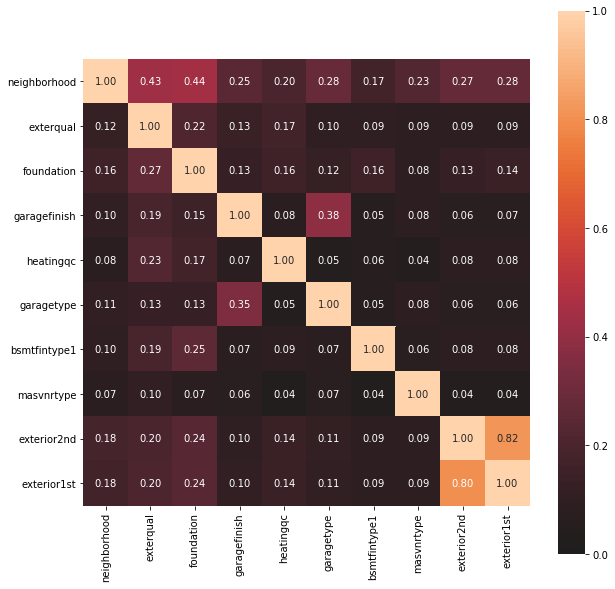

{'corr':               neighborhood  exterqual  foundation  garagefinish  heatingqc  \
 neighborhood      1.000000   0.431355    0.439727      0.245090   0.199316   
 exterqual         0.123974   1.000000    0.215728      0.133508   0.169772   
 foundation        0.160065   0.273227    1.000000      0.131706   0.158675   
 garagefinish      0.102720   0.194689    0.151642      1.000000   0.078049   
 heatingqc         0.076047   0.225379    0.166318      0.071053   1.000000   
 garagetype        0.108315   0.130083    0.130347      0.349166   0.045352   
 bsmtfintype1      0.100314   0.192360    0.253525      0.070998   0.086609   
 masvnrtype        0.074362   0.101923    0.072740      0.063995   0.035292   
 exterior2nd       0.182482   0.202514    0.239462      0.099301   0.139783   
 exterior1st       0.178130   0.204398    0.240793      0.103552   0.138445   
 
               garagetype  bsmtfintype1  masvnrtype  exterior2nd  exterior1st  
 neighborhood    0.283415      0.172131  

In [144]:
# plot corr between 10 cat features with highest corr to target
top10_feats = corr_target_cat_feats.head(10)['cat_feat']
associations(data[top10_feats], theil_u=True, figsize=(10, 10))

In [184]:
# to reduce minority 
data['zone_type'] = data['mszoning'].apply(fold_zone_type)
data['adjacency'] = data['condition1'].apply(to_adjacency)
train_part, test_part = get_train_tests(data, target)

In [185]:
[correlation_ratio(train_part[cf], train_part[target]) 
 for cf in ['zone_type', 'adjacency']
]

[0.28880288249977604, 0.17293552989193986]

## Encode categorical features

I will perform onehot encoding incrementally, starting with features having highest correlations with target.

In [152]:
check_na(data[['neighborhood']])

,column,na_count


In [176]:
# nbhood
encoded_data, nbh_feats = onehot_encode('neighborhood', data)
print(encoded_data.shape)

there are 25 categories as follows:
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
(2919, 108)


In [163]:
encoded_data[nbh_feats] .head()

,neighborhood_CollgCr,neighborhood_Veenker,neighborhood_Crawfor,neighborhood_NoRidge,neighborhood_Mitchel,neighborhood_Somerst,neighborhood_NWAmes,neighborhood_OldTown,neighborhood_BrkSide,neighborhood_Sawyer,...,neighborhood_Edwards,neighborhood_Timber,neighborhood_Gilbert,neighborhood_StoneBr,neighborhood_ClearCr,neighborhood_NPkVill,neighborhood_Blmngtn,neighborhood_BrDale,neighborhood_SWISU,neighborhood_Blueste
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [164]:
train_part, test_part = get_train_tests(encoded_data, target)

In [165]:
feats += nbh_feats
X_train = train_part[feats]
X_test = test_part[feats]

## TODO: drop non-important feats

In [ ]:
to_drop = ['saletype', 'salecondition']

# Random forest



## Base RF

No tuning yet.

In [ ]:
base_rf = RandomForestRegressor(n_estimators=100, max_features=1.0, n_jobs=-1,
                               random_state=1,
                               )

In [166]:
base_rf.fit(X_train, y_train)
rf_score = round(base_rf.score(X_train, y_train), 4)
rf_score

RandomForestRegressor(max_features=1.0, n_jobs=-1, random_state=1)

In [170]:
y_pred = base_rf.predict(X_test)
make_output(y_pred).to_csv('output/rf_res.csv', index=False)

In [ ]:
100 * (rf_score - lr_score)/lr_score

In [172]:
100 * (rf_score - 0.7968)/0.7968

22.929216867469894

+ adding neighborhood has a whooping effect. It boosts score by >20% and advanced me >450 places on leaderboard.
+ now we add the next relevant categorical var, "foundation" (this is because kitchen and exterior qualities are already added). But should expect that the impact may be marginal, as the correlation is not that high.

In [173]:
# adding foundation
data.foundation.value_counts()

PConc     1308
CBlock    1235
BrkTil     311
Slab        49
Stone       11
Wood         5
Name: foundation, dtype: int64

In [174]:
check_na(data[['foundation']])

,column,na_count


In [177]:
encoded_data, fdn_feats = onehot_encode('foundation', encoded_data)

there are 6 categories as follows:
['PConc' 'CBlock' 'BrkTil' 'Wood' 'Slab' 'Stone']


In [178]:
train_part, test_part = get_train_tests(encoded_data, target)

In [179]:
feats += fdn_feats
X_train = train_part[feats]
X_test = test_part[feats]

In [180]:
base_rf.fit(X_train, y_train)
rf_score = round(base_rf.score(X_train, y_train), 4)
rf_score

0.9798

In [181]:
make_output(base_rf.predict(X_test)).to_csv('output/rf_res.csv', index=False)

+ as expected "foundation" not help at all, it even pulls down perf.

## TODO: add derived features

In [163]:
# add some derived features
data['age_from_built'] = data.apply(axis=1, func=cal_age_from_built)

# total bathroom
data['total_bath'] = data['fullbath'] + data['halfbath']

In [183]:
train_part, test_part = get_train_tests(data, target)

## Tuning RF via grid search

I will try later.